# Clustering ETFs

This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

## Dependencies

This notebook requires code from:
    
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

## Table of Contents
    
    1. Commodity ETFs - entire workflow application example

### Import Libraries

In [2]:
import numpy as np
np.random.seed(1) # NumPy
import random
random.seed(3) # Python
import tensorflow as tf
tf.set_random_seed(2) # Tensorflow
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import pandas as pd
import pickle

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

# Import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

/Users/simaomoraessarmento/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
config_file = 'config/config_commodities_2010_2019.json'

### Import Configurations

In [5]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [6]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

In [7]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

# 1. Commodity ETFs Dataset

In this section, we proceed to analyze ETFs from different commodity sectors and detect possible interesting pairs. The process goes as follows:

- Upload time series corresponding to ETFs
- Apply dimensionality reduction and cluster securities
- Run cointegration tests for securities within the same cluster

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [8]:
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_long_updated')

In [44]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2009',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 208 tickers
Total of 71 tickers after removing tickers with Nan values


In [48]:
len(df_prices_train)+len(df_prices_test)

2516

# 1. No Clustering

In [166]:
no_cluster_series = pd.Series(0,index = df_prices_train.columns)
pairs_all_a_all, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=no_cluster_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=5,
                                                            min_zero_crosings=12*6,
                                                            p_value_threshold=0.05,
                                                            hurst_threshold=0.4
                                                            )
pairs_found_all_a_all = len(pairs_all_a_all)
print('Found {} pairs'.format(pairs_found_all_a_all))

Found 100 pairs
The pairs contain 57 unique tickers
Found 100 pairs


In [167]:
print('Out of {} possible combinations'.format(len(df_prices_train.columns)*(len(df_prices_train.columns)-1)/2))

Out of 2485.0 possible combinations


**Save pairs in `pickle` file**

In [ ]:
with open('data/etfs/pickle/pairs_unfiltered.pickle', 'wb') as f:
    pickle.dump(pairs_all_a_all, f)

# 2. Clustering by Category

In [45]:
segment_mapper = {
                'Commodities: Agriculture':'Agriculture',
                'Commodities: Agriculture Cocoa':'Agriculture',
                'Commodities: Agriculture Coffee':'Agriculture',
                'Commodities: Agriculture Corn':'Agriculture',
                'Commodities: Agriculture Cotton':'Agriculture',
                'Commodities: Agriculture Grains':'Agriculture',
                'Commodities: Agriculture Livestock':'Agriculture',
                'Commodities: Agriculture Softs':'Agriculture',
                'Commodities: Agriculture Soybeans':'Agriculture',
                'Commodities: Agriculture Sugar':'Agriculture',
                'Commodities: Agriculture Wheat':'Agriculture',
                'Equity: Global Water':'Agriculture',
                'Commodities: Broad Market':'Broad Market',
                'Commodities: Broad Market Metals':'Broad Market',
                'Commodities: Energy':'Energy',
                'Commodities: Energy Crude Oil':'Energy',
                'Commodities: Energy Gasoline':'Energy',
                'Commodities: Energy Natural Gas':'Energy',
                'Inverse Commodities: Energy Crude Oil':'Energy',
                'Inverse Commodities: Energy Natural Gas':'Energy',
                'Leveraged Commodities: Energy Crude Oil':'Energy',
                'Leveraged Commodities: Energy Natural Gas':'Energy',
                'Equity: U.S. MLPs':'Energy',
                'Equity: U.S. Energy':'Energy',
                'Inverse Equity: U.S. Energy':'Energy',
                'Equity: U.S. Oil & Gas Exploration & Production':'Energy',
                'Equity: U.S. Oil & Gas Equipment & Services':'Energy',
                'Equity: Global Energy':'Energy',
                'Equity: Global Nuclear Energy':'Energy',
                'Equity: Global Oil & Gas Equipment & Services':'Energy',
                'Equity: U.S. Natural Gas':'Energy',
                'Equity: Global Coal':'Energy',
                'Leveraged Equity: U.S. Energy':'Energy',
                'Commodities: Industrial Metals':'Industrial Metals',
                'Commodities: Industrial Metals Aluminum':'Industrial Metals',
                'Commodities: Industrial Metals Copper':'Industrial Metals',
                'Commodities: Industrial Metals Lead':'Industrial Metals',
                'Commodities: Industrial Metals Nickel':'Industrial Metals',
                'Commodities: Industrial Metals Tin':'Industrial Metals',
                'Equity: U.S. Metals & Mining':'Industrial Metals',
                'Commodities: Precious Metals':'Precious Metals',
                'Commodities: Precious Metals Gold':'Precious Metals',
                'Commodities: Precious Metals Palladium':'Precious Metals',
                'Commodities: Precious Metals Platinum':'Precious Metals',
                'Commodities: Precious Metals Silver':'Precious Metals',
                'Inverse Commodities: Precious Metals Gold':'Precious Metals',
                'Inverse Commodities: Precious Metals Silver':'Precious Metals',
                'Leveraged Commodities: Precious Metals Gold': 'Precious Metals',
                'Leveraged Commodities: Precious Metals Silver':'Precious Metals',
                'Equity: Global Gold Miners':'Precious Metals'}

clustering_mapper = {'Agriculture':1, 'Broad Market': 2,'Energy':3, 'Industrial Metals':4, 'Precious Metals':5}

In [46]:
with open(config['dataset']['ticker_segment_dict'], 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

df_category = pd.DataFrame(data =df_prices_train.columns, columns=['Ticker'])
df_category['Segment'] = df_category['Ticker'].apply(lambda row: ticker_segment_dict[row])
df_category['Category'] = df_category['Segment'].apply(lambda row: segment_mapper[row])
df_category['Category_cluster'] = df_category['Category'].apply(lambda row: clustering_mapper[row])
df_category = df_category.set_index('Ticker')

In [138]:
pairs_category, unique_tickers = series_analyser.get_candidate_pairs(
                                                            clustered_series=df_category['Category_cluster'],
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=5,
                                                            min_zero_crosings=12*6,
                                                            p_value_threshold=0.05,
                                                            hurst_threshold=0.4
                                                            )
pairs_found_category = len(pairs_category)

Found 33 pairs
The pairs contain 37 unique tickers


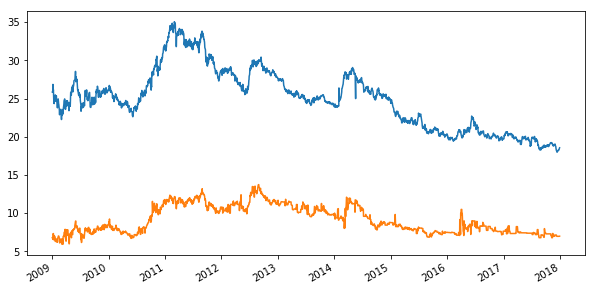

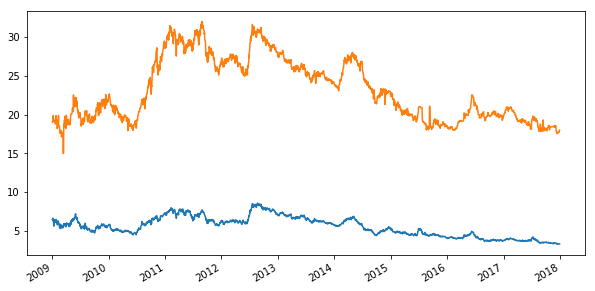

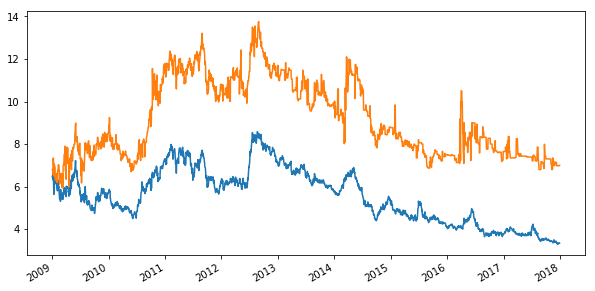

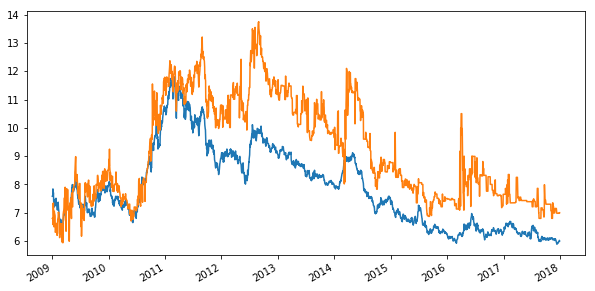

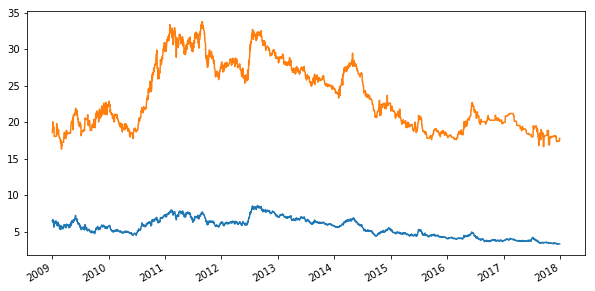

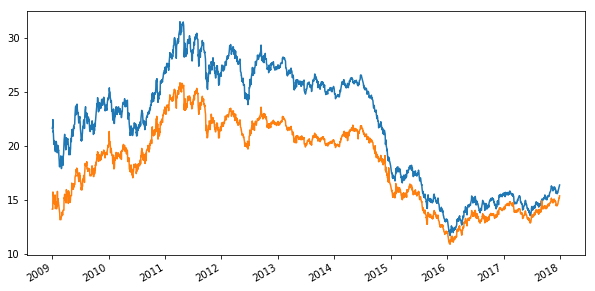

In [139]:
# examples
for i in range(6):
    plt.figure(figsize=(10,5))
    pairs_category[i][2]['X_train'].plot()
    pairs_category[i][2]['Y_train'].plot()

**Save in `pickle` file**

In [140]:
with open('data/etfs/pickle/pairs_category.pickle', 'wb') as f:
    pickle.dump(pairs_category, f)

# 3. Clustering using Usupervised Learning

## PCA on returns

A purely fundamental approach is a one way to search for pairs, however breadth will likely be low. Sharpe can be maximized by having high breadth (high number of bets). With N stocks in the universe, there are N*(N-1)/2 pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results due to comparison bias. As such, we narrow down the search space in a reasonable way, assuming ETFs that share loadings to common factors (defined below) in the past should be related in the future.

**Obtain returns**

In [76]:
df_returns = data_processor.get_return_series(df_prices_train)
df_returns.head()

,AGQ,CGW,DBA,DBB,DBC,DBE,DBO,DBP,DBS,DDG,...,UNG,USL,USO,USV,VDE,XES,XLE,XME,XOP,ZSL
2009-01-05,-0.044248,0.004798,0.006886,0.001609,0.010488,0.029275,0.043771,-0.018553,-0.022789,-0.018759,...,0.016929,0.025969,0.046871,0.000000,0.025544,0.041051,0.023529,0.040119,0.046954,0.067449
2009-01-06,0.031290,0.007503,0.031535,0.045783,0.026173,0.012190,0.012442,0.010653,0.023816,-0.004101,...,-0.015854,-0.001858,-0.001340,0.000000,0.014370,0.046793,0.010910,0.035703,0.014242,-0.050549
2009-01-07,-0.078638,-0.025051,-0.036096,-0.033794,-0.051011,-0.065120,-0.071461,-0.029922,-0.044111,0.046280,...,-0.021345,-0.052792,-0.106846,-0.071989,-0.044387,-0.045203,-0.042397,-0.072946,-0.049298,0.069444
2009-01-08,0.019153,0.007639,0.003057,-0.028609,0.003707,-0.000477,0.009314,0.022433,0.016227,-0.012413,...,-0.046914,0.033022,-0.002104,0.016518,0.014542,0.015781,0.012880,0.039509,0.011942,-0.019481
2009-01-09,0.013848,-0.031013,0.007619,0.041726,-0.011542,-0.011456,-0.016513,-0.005142,0.008483,0.026977,...,-0.013385,-0.043817,-0.025000,0.014375,-0.036738,-0.052822,-0.033578,-0.048547,-0.038509,-0.029801


In [77]:
print('Total number of possible pairs: ', len(df_returns.columns)*(len(df_returns.columns)-1)/2)

Total number of possible pairs:  2485.0


**Applying PCA on Returns**

- Protecting from `Curse of Dimensionality` - *source: https://stats.stackexchange.com/questions/232500/how-do-i-know-my-k-means-clustering-algorithm-is-suffering-from-the-curse-of-dim*: Perform a principle components analysis (PCA) and look at how the eigenvalues drop off. It is quite common that most of the variation exists in a couple of dimensions (which typically cut across the original dimensions of your dataset)

To analyze how many principal components we should be using, and accounting for the fact that too many features might incur curse of dimensionality, we proceed to visualize the explanatory power of the first 20 features. We observe that most of the information is in fact contained within the first features. We choose to keep the first 14.

In [78]:
# this show us the feature importance of the 
N_PRIN_COMPONENTS = 20
_, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[0.01767719 0.00544133 0.00249242 0.00102489 0.0007027  0.00066625
 0.00056415 0.00046312 0.00033009 0.00028296 0.00027131 0.00024491
 0.00019441 0.00017675 0.00017216 0.00015576 0.000145   0.00014302
 0.0001314  0.00010814]


In [154]:
N_PRIN_COMPONENTS = 3#config['PCA']['N_COMPONENTS']
X, explained_variance = series_analyser.apply_PCA(N_PRIN_COMPONENTS, df_returns)
print(explained_variance)

[0.01767719 0.00544133 0.00249242]


**Clustering**

We will make use of the DBSCAN unsupervised clustering algorithm, which is available in scikit-learn. DBSCAN has advantages in this use case, specifically:

- DBSCAN does not cluster all stocks; it leaves out stocks which do not neatly fit into a cluster;
- No need to specify the number of clusters.

The clustering algorithm will give us sensible candidate pairs. We will need to do some validation in the next step.

In [155]:
clustered_series_all, clustered_series, counts, clf = series_analyser.apply_DBSCAN(config['clustering']['epsilon'],
                                                                                   config['clustering']['min_samples'],
                                                                                   X,
                                                                                   df_returns)

Clusters discovered: 6
Pairs to evaluate: 538


The epsilon parameter strongly dependens on the data. Because of the that, it is not obvious wether DBSCAN is the best algo.

In [156]:
print(counts)

1    25
0    20
2    10
5     2
4     2
3     2
dtype: int64


### Optimize according to Silhouette

When performing PCA, use number of components that maximizes the silhouette coefficient after clustering.

In [ ]:
config['clustering']={"algo": "DBSCAN",
                      "epsilon": 0.4,
                      "min_samples": 2}
X, clustered_series_all, clustered_series, counts, clf = series_analyser.clustering_for_optimal_PCA(1,
                                                                                  20,
                                                                                  df_returns,
                                                                                  config['clustering'])

**Fundamental analysis for clusters**

In [157]:
etfs, etfs_unique, tickers = \
            data_processor.read_ticker_excel(path='data/etfs/commodity_ETFs_long_updated.xlsx')

In [158]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    print('\nCluster {}:\n{}'.format(label_n, etfs_cluster_n[['Ticker', 'Segment']]))


Cluster 0:
    Ticker                                          Segment
375    CGW                             Equity: Global Water
166    FCG                         Equity: U.S. Natural Gas
376    FIW                             Equity: Global Water
164    FXN                              Equity: U.S. Energy
159    IEO  Equity: U.S. Oil & Gas Exploration & Production
165    IEZ      Equity: U.S. Oil & Gas Equipment & Services
149    IXC                            Equity: Global Energy
153    IYE                              Equity: U.S. Energy
277    NLR                    Equity: Global Nuclear Energy
152    OIH    Equity: Global Oil & Gas Equipment & Services
374    PHO                             Equity: Global Water
377    PIO                             Equity: Global Water
182    PXE  Equity: U.S. Oil & Gas Exploration & Production
175    PXI                              Equity: U.S. Energy
195    PXJ      Equity: U.S. Oil & Gas Equipment & Services
163    RYE                  

**Visualizing with t-sne**

In [159]:
def plot_TSNE(X, clf, clustered_series_all):
    """
    This function makes use of t-sne to visualize clusters in 2d.
    """
    X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X) 
    
    # visualization
    plt.figure(1, facecolor='white', figsize=(15,5))
    plt.clf()
    plt.axis('off')

    labels = clf.labels_
    plt.scatter(
        X_tsne[(labels!=-1), 0],
        X_tsne[(labels!=-1), 1],
        s=100,
        alpha=0.85,
        c=labels[labels!=-1],
        cmap=cm.Paired
    )

    plt.scatter(
        X_tsne[(clustered_series_all==-1).values, 0],
        X_tsne[(clustered_series_all==-1).values, 1],
        s=100,
        alpha=0.10
    )

    plt.title('T-SNE of all ETFs with DBSCAN Clusters Noted');

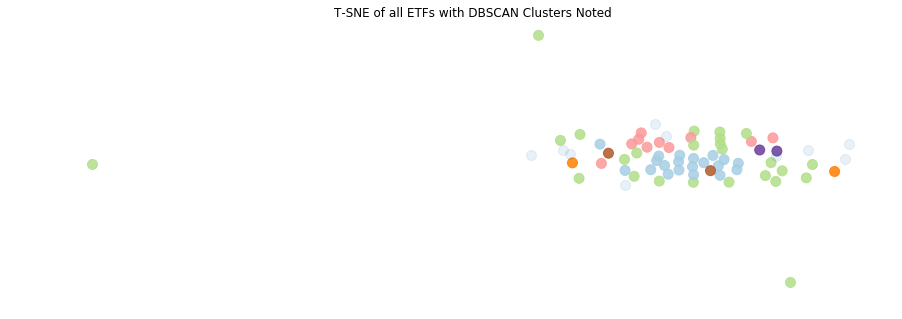

In [160]:
plot_TSNE(X,clf, clustered_series_all)

What can we conclude??
- First of all, the securities in each cluster are indeed from segments tham seem to be fundamentally related.
- Moreover, we see that some filtering is being performed, and the clustering goes further than a simple groupby segment would.

Let's proceed to plot the identified time series.

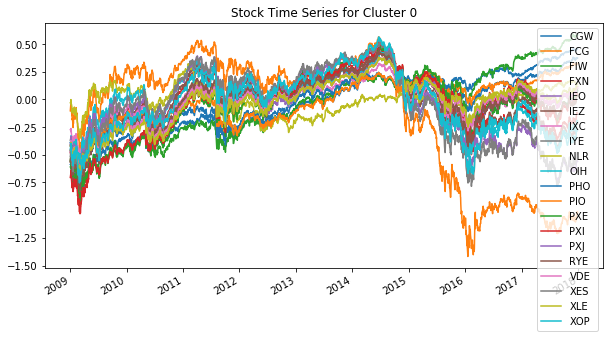

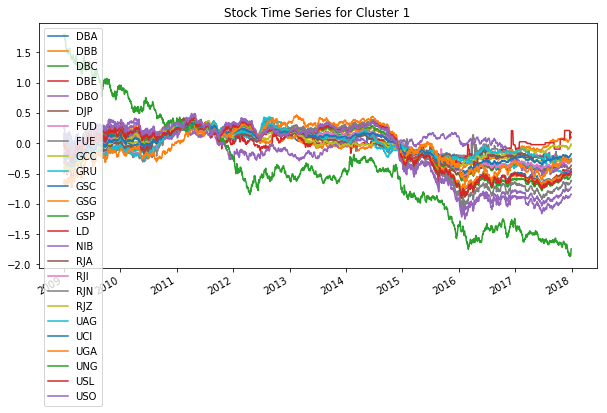

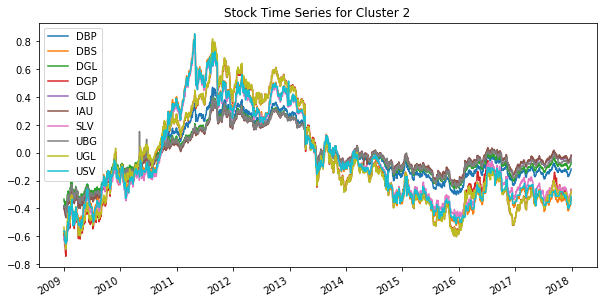

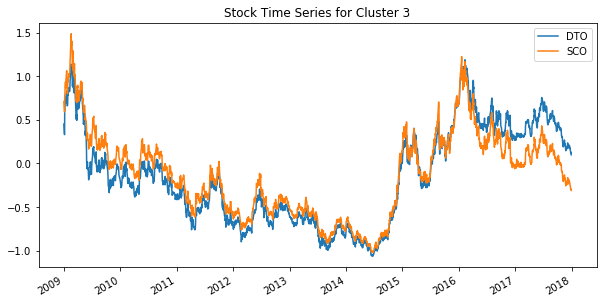

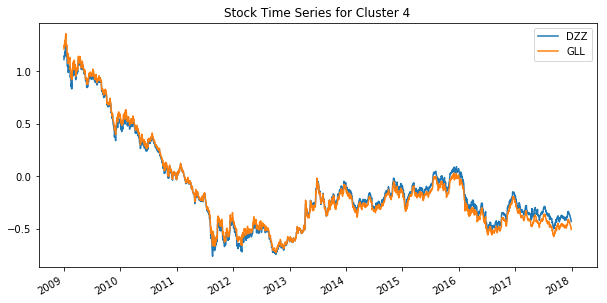

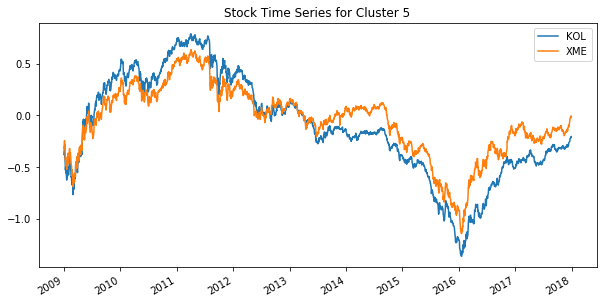

In [161]:
for clust in range(len(counts)):
    symbols = list(clustered_series[clustered_series==clust].index)
    means = np.log(df_prices_train[symbols].mean())
    series = np.log(df_prices_train[symbols]).sub(means)
    series.plot(title='Stock Time Series for Cluster %d' % clust, figsize=(10,5))

We now investigate whether it is possible to find cointegrated pairs within the clusters

In [162]:
pairs_unsupervised, unique_tickers = series_analyser.get_candidate_pairs(clustered_series=clustered_series,
                                                            pricing_df_train=df_prices_train,
                                                            pricing_df_test=df_prices_test,
                                                            min_half_life=5,
                                                            min_zero_crosings=12*6,
                                                            p_value_threshold=0.05,
                                                            hurst_threshold=0.4
                                                            )

Found 34 pairs
The pairs contain 31 unique tickers


In [163]:
for pair in pairs_unsupervised:
    print('------------------------------------------------')
    print('Leg 1: {}. Segment: {}. Category: {}'.format(pair[0], df_category.loc[pair[0]]['Segment'] ,
                                                        df_category.loc[pair[0]]['Category']))
    print('Leg 2: {}. Segment: {}. Category: {}'.format(pair[1], df_category.loc[pair[1]]['Segment'],
                                                        df_category.loc[pair[1]]['Category']))

------------------------------------------------
Leg 1: IEO. Segment: Equity: U.S. Oil & Gas Exploration & Production. Category: Energy
Leg 2: PXI. Segment: Equity: U.S. Energy. Category: Energy
------------------------------------------------
Leg 1: IEZ. Segment: Equity: U.S. Oil & Gas Equipment & Services. Category: Energy
Leg 2: XOP. Segment: Equity: U.S. Oil & Gas Exploration & Production. Category: Energy
------------------------------------------------
Leg 1: IXC. Segment: Equity: Global Energy. Category: Energy
Leg 2: RYE. Segment: Equity: U.S. Energy. Category: Energy
------------------------------------------------
Leg 1: IYE. Segment: Equity: U.S. Energy. Category: Energy
Leg 2: PXI. Segment: Equity: U.S. Energy. Category: Energy
------------------------------------------------
Leg 1: DBA. Segment: Commodities: Agriculture. Category: Agriculture
Leg 2: FUE. Segment: Commodities: Agriculture Grains. Category: Agriculture
------------------------------------------------
Leg 1: 

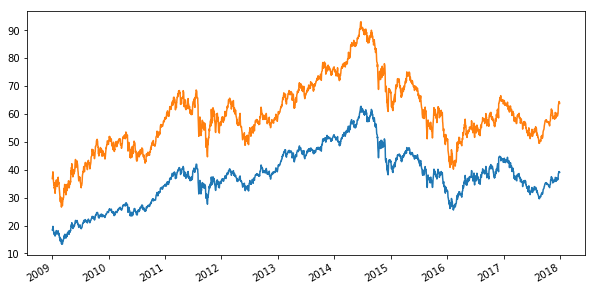

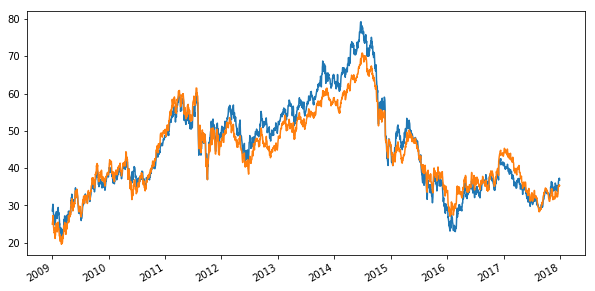

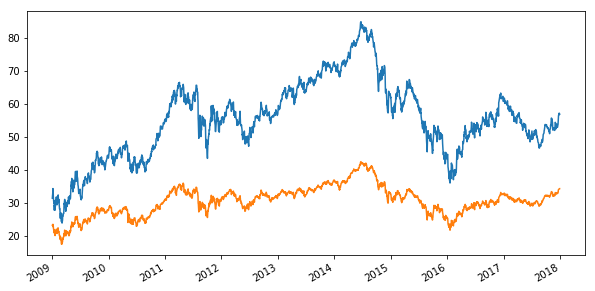

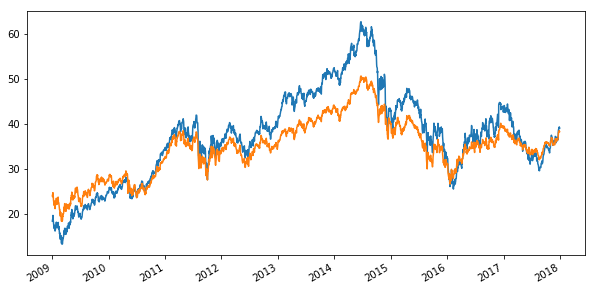

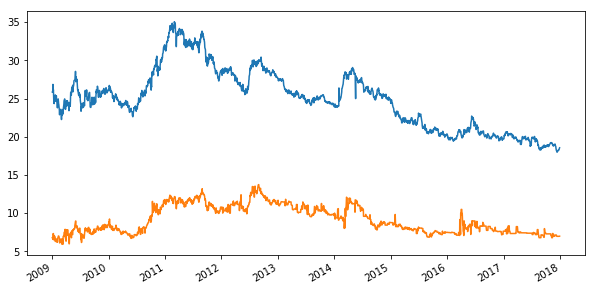

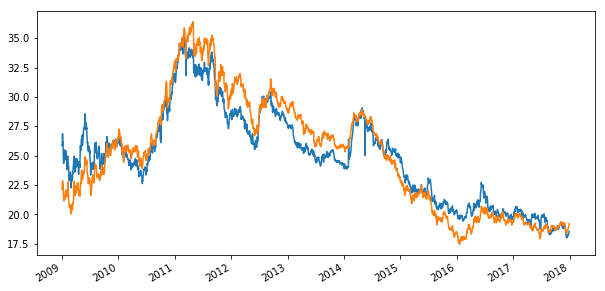

In [164]:
# examples
for i in range(6):
    plt.figure(figsize=(10,5))
    pairs_unsupervised[i][2]['X_train'].plot()
    pairs_unsupervised[i][2]['Y_train'].plot()

In [165]:
with open('data/etfs/pickle/pairs_unsupervised_learning.pickle', 'wb') as f:
    pickle.dump(pairs_unsupervised, f)